# Preprocess the track data

There are a few tasks to complete on the track data before they are used in the paper analysis.

### These two functions calculate track durations, as well as find slices that happen between the first and last time a slice was 100,000 sq. km within each track.

In [1]:
import numpy as np

def calc_duration(x):
    r"""Calculates the total duration of each track in hours.  Although the code is
    set up to be resistant to disordered datetime indexes, generally these should be
    in chronological order.
    ----------
    x: DatetimeIndex
        Datetime representing the valid time for each slice within a unique track.

    Returns
    -------
    duration: integer
        The number of hours between the first and last slice within a track.
    """
    duration = (np.max(x) - np.min(x)).total_seconds() / 3600
    
    return duration

def find_runs(subset):
    r"""Determines if a slice is between the first and last occurrence of a slices
    that meet a particular condition (e.g., an area greater than 100,000 sq. km)
    ----------
    subset: GeoDataFrame
        GeoDataFrame representing slices within a track. Requires 'large_slice' to
        to have a value of 0 or 1.

    Returns
    -------
    between: array-like
        List of bools, True if between two slices that meet the conditions, false if not.
    """
    bf = subset['large_slice'].bfill().values
    ff = subset['large_slice'].ffill().values
    
    between = ~np.isnan(bf) & ~np.isnan(ff)

    return between.astype(float)

# Read in track information for 2012-2013

If you get a shapely error reading in the file, change the first line below to access prior version:

```
paper_preproc = pickle.load(open("../example_data/pre_CTRL_2012_2013_py.pkl", 'rb'))
```

In [2]:
import pickle 

dset = 'CTRL'
year = 2012

with open(f"../example_data/{dset}_{year}_{year+1}_py312.pkl", "rb") as f:
    tracks = pickle.load(f)

tracks.head()

,area,convex_area,coords,coords_50p,coords_90p,eccentricity,geometry,intensity_variance,major_axis_length,max_intensity,...,start_hour,start_month,start_time,start_year,xmax,xmin,ymax,ymin,datetime,storm_num
0,2032.0,2384.0,"[[937, 345], [937, 346], [938, 344], [938, 345...","[[940, 342], [940, 343], [940, 344], [941, 341...",[],0.741318,"POLYGON ((943 338, 939 342, 937 345, 937 346, ...",0.192474,64.455741,1.836239,...,6,10,2012-10-02 06:00:00,2012,356,338,950,937,2012-10-02 06:00:00,0.0
1,688.0,896.0,"[[944, 386], [944, 387], [945, 385], [945, 386...","[[946, 386], [947, 385], [947, 386], [948, 384...",[],0.844213,"POLYGON ((948 383, 945 385, 944 386, 944 387, ...",0.049803,47.533864,0.996987,...,6,10,2012-10-02 06:00:00,2012,390,383,954,944,2012-10-02 06:00:00,1.0
2,128.0,128.0,"[[947, 334], [947, 335], [948, 333], [948, 334...","[[949, 333]]",[],0.884338,"POLYGON ((949 332, 947 334, 947 335, 948 335, ...",0.018417,18.031576,0.520575,...,6,10,2012-10-02 06:00:00,2012,335,332,949,947,2012-10-02 06:00:00,2.0
3,1040.0,1440.0,"[[951, 334], [951, 335], [951, 336], [951, 337...","[[952, 333], [952, 334], [952, 335], [953, 329...","[[953, 330], [953, 331], [953, 332], [953, 333...",0.833672,"POLYGON ((953 327, 952 330, 951 334, 951 337, ...",4.032813,55.758451,7.914831,...,6,10,2012-10-02 06:00:00,2012,337,327,961,951,2012-10-02 06:00:00,3.0
4,160.0,192.0,"[[960, 321], [961, 321], [962, 320], [962, 321...","[[963, 321]]",[],0.826857,"POLYGON ((962 320, 960 321, 962 322, 964 322, ...",0.011030,19.374035,0.463909,...,6,10,2012-10-02 06:00:00,2012,322,320,964,960,2012-10-02 06:00:00,4.0


# Preprocess the data

### Set the dataset (CTRL or PGW) and the seasonal string and combine it with the storm_num

This assures that the track numbers are unique across all seasons

In [3]:
tracks['dataset'] = dset
seas_str = "{}_{}".format(year, year+1)
tracks['season'] = seas_str
tracks['storm_num'] = [dset + "_" + seas_str + "_" + str(int(x)) for x in tracks['storm_num']]

### Set the datetime as the index

In [4]:
import pandas as pd

tracks['datetime'] = pd.to_datetime(tracks['datetime'])
tracks = tracks.set_index('datetime', drop=False)

### Calculate total SWE in cubic km

See paper for info, but this takes the mean intensity (in SWE mm) and converts it to km.

Then, the area over which that mean was calculated is multiplied by this value to get a 3-hr cubic km total.

In [5]:
mm_to_km = tracks['mean_intensity'].values * 10**-6
km3 = mm_to_km * tracks['area'].values

tracks['total_SWE_km3'] = km3

### Calculate the duration for each unique storm

In [6]:
grouped = tracks.groupby('storm_num')
tracks['duration'] = grouped['storm_num'].transform(lambda x: calc_duration(x.index))

### Calculate the total area for 50th and 90th percentile SWE occurrences

In [7]:
tracks['area_50_p'] = [16*len(x) for x in tracks.coords_50p]
tracks['area_90_p'] = [16*len(x) for x in tracks.coords_90p]

# Select tracks that meet certain criteria

### First, only those that lasted 24 hours

In [8]:
tracks = tracks[tracks['duration'] >= 24].copy()

### Next, identify tracks that have at least one occurrence of a slice with an area exceeding 100,000 sq. km

In [9]:
large_slices = tracks[tracks['area'] >= 100000].copy()

tracks = tracks[tracks['storm_num'].isin(np.unique(large_slices['storm_num']))].copy()

### Next, identify slices that occur between the first and last 100,000 sq. km slices in a track

In [10]:
#Set flag column for if the slice is between the two instances to nan
tracks['100k_between'] = np.nan

#Set flag column for if the slice is larger than 100,000 sq. km to nan

tracks['large_slice'] = np.nan

#If the slice is larger than 100,000 sq. km, set column to 1, otherwise it is nan
tracks.loc[tracks['area'] >= 100000, 'large_slice'] = 1

#Group the slices by storm_num
grouped = tracks.groupby('storm_num')

#Set the 100k_between column to 1 or 0 depending on if the slice within the track
#is between the first and last instances of 'large_slice' in each track
for gid, group in grouped:

    tracks.loc[tracks['storm_num']==gid, '100k_between'] = find_runs(group.copy())

### Finally, get only those tracks where the duration between the first and last 100,000 sq. km slice instances is at least 24 hours

In [11]:
#Get only the slices between the first and last instances 
large_long_tracks = tracks[tracks['100k_between'] == True].copy()

#Calculate the duration of only those runs
grouped = large_long_tracks.groupby('storm_num')
large_long_tracks['long_duration'] = grouped['storm_num'].transform(lambda x: calc_duration(x.index))

#Set a new column in the original list that keeps the duration of these runs
tracks['long_duration'] = np.nan

#For each storm track, set the long_duration column based on this calculation
for gid, group in grouped:

    tracks.loc[tracks['storm_num']==gid, 'long_duration'] = group['long_duration'].values[0]

# Get only those slices from tracks with large slice durations greater than 24 hours and are between the first and last instances of large slices

In [12]:
tracks = tracks[(tracks['long_duration'] >= 24) & (tracks['100k_between']==True)].copy()

### Sanity checks

Do the new tracks have at least two "large slices" within them?

In [13]:
np.min(tracks[tracks['area'] >= 100000].groupby('storm_num').count()['area'])

np.int64(6)

Do the new tracks have a minimum duration of 24 hours...

In [14]:
tmp = tracks.groupby('storm_num').first()
np.min(tmp['duration'])

np.float64(27.0)

... and minimum long duration of 24 hours?

In [15]:
np.min(tmp['long_duration'])

np.float64(24.0)

Is the max long duration reasonable?

In [16]:
np.max(tmp['long_duration'])

np.float64(210.0)

# Are the values reasonable?

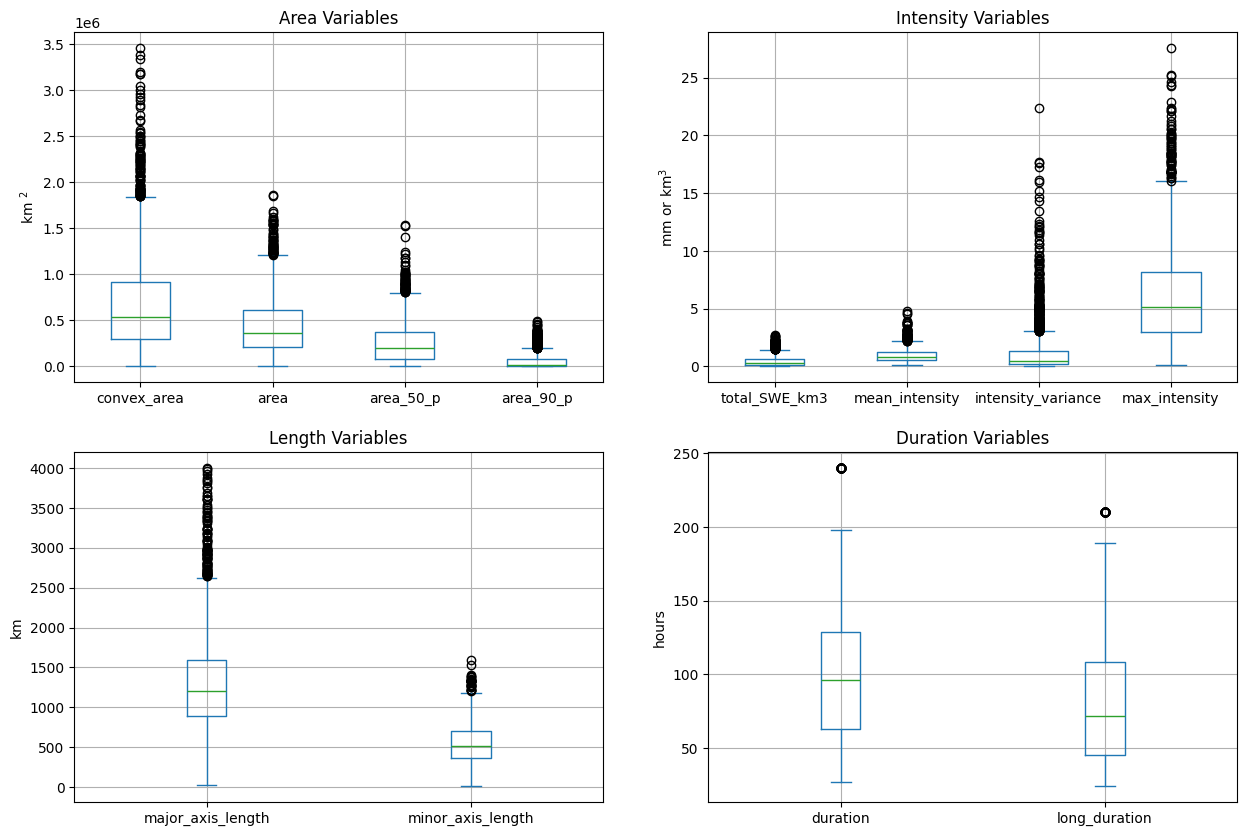

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 10

plot_dict = {'Area': {'vars': ['convex_area', 'area', 'area_50_p', 'area_90_p'], 'units': 'km $^{2}$'},
             'Intensity': {'vars': ['total_SWE_km3', 'mean_intensity', 'intensity_variance', 'max_intensity'], 'units': 'mm or km$^{3}$'},
             'Length': {'vars': ['major_axis_length', 'minor_axis_length'], 'units': 'km'},
             'Duration': {'vars': ['duration', 'long_duration'], 'units': 'hours'}}

for ax_num, (var_type, var_data) in enumerate(plot_dict.items()):
    
    ax = plt.subplot(2, 2, ax_num+1)

    ax = tracks[var_data['vars']].plot(kind='box', ax=ax)

    ax.set_ylabel(var_data['units'])

    ax.set_title(f"{var_type} Variables")

    ax.grid()

# Read in the paper data and compare

If you get a shapely error reading in the file, change the first line below to access prior version:

```
paper_preproc = pickle.load(open("../example_data/pre_CTRL_2012_2013_py.pkl", 'rb'))
```

In [18]:
paper_preproc = pickle.load(open("../example_data/pre_CTRL_2012_2013_py312.pkl", 'rb'))

paper_preproc = paper_preproc[(paper_preproc['long_duration'] >= 24) & (paper_preproc['100k_between']==True)].copy()

paper_preproc.head()

,area,convex_area,coords,coords_50p,coords_90p,eccentricity,geometry,intensity_variance,major_axis_length,max_intensity,...,storm_num,dataset,season,total_SWE_km3,duration,area_50_p,area_90_p,100k_between,large_slice,long_duration
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-04 09:00:00,141664.0,199872.0,"[[659, 683], [659, 684], [659, 685], [659, 686...","[[664, 686], [665, 685], [665, 686], [665, 687...","[[673, 689], [674, 689], [674, 690], [675, 689...",0.911391,"POLYGON ((710 630, 691 634, 680 639, 676 641, ...",0.500083,724.124229,3.304748,...,CTRL_2012_2013_101,CTRL,2012_2013,0.123856,84.0,88528,11312,True,1.0,54.0
2012-10-04 12:00:00,343824.0,480336.0,"[[658, 686], [658, 687], [658, 688], [658, 689...","[[669, 690], [669, 691], [669, 693], [669, 694...","[[705, 719], [706, 711], [706, 719], [706, 720...",0.968593,"POLYGON ((692 652, 690 653, 687 655, 686 656, ...",0.931972,1456.897648,7.807863,...,CTRL_2012_2013_101,CTRL,2012_2013,0.322211,84.0,200048,40928,True,1.0,54.0
2012-10-04 15:00:00,343504.0,452800.0,"[[692, 713], [692, 714], [693, 713], [693, 714...","[[703, 719], [703, 720], [704, 719], [704, 720...","[[711, 737], [711, 738], [711, 739], [712, 737...",0.942244,"POLYGON ((730 687, 726 689, 692 713, 692 714, ...",1.976959,1237.389848,9.538871,...,CTRL_2012_2013_101,CTRL,2012_2013,0.414629,84.0,224432,63152,True,1.0,54.0
2012-10-04 18:00:00,321936.0,452800.0,"[[706, 721], [706, 722], [707, 721], [707, 722...","[[719, 767], [719, 768], [720, 768], [720, 769...","[[732, 760], [732, 761], [732, 762], [733, 759...",0.921177,"POLYGON ((794 687, 708 720, 706 721, 706 722, ...",2.491788,1137.923048,10.356344,...,CTRL_2012_2013_101,CTRL,2012_2013,0.426544,84.0,215152,61232,True,1.0,54.0
2012-10-04 21:00:00,345168.0,479568.0,"[[736, 730], [737, 717], [737, 718], [737, 729...","[[742, 768], [742, 769], [743, 767], [743, 768...","[[756, 762], [756, 763], [756, 774], [756, 775...",0.903394,"POLYGON ((837 672, 834 673, 764 700, 740 712, ...",7.145257,1122.095829,15.378941,...,CTRL_2012_2013_101,CTRL,2012_2013,0.702544,84.0,248656,90784,True,1.0,54.0


# Compare storm counts in both datasets

Paper data:

paper data track count: 113


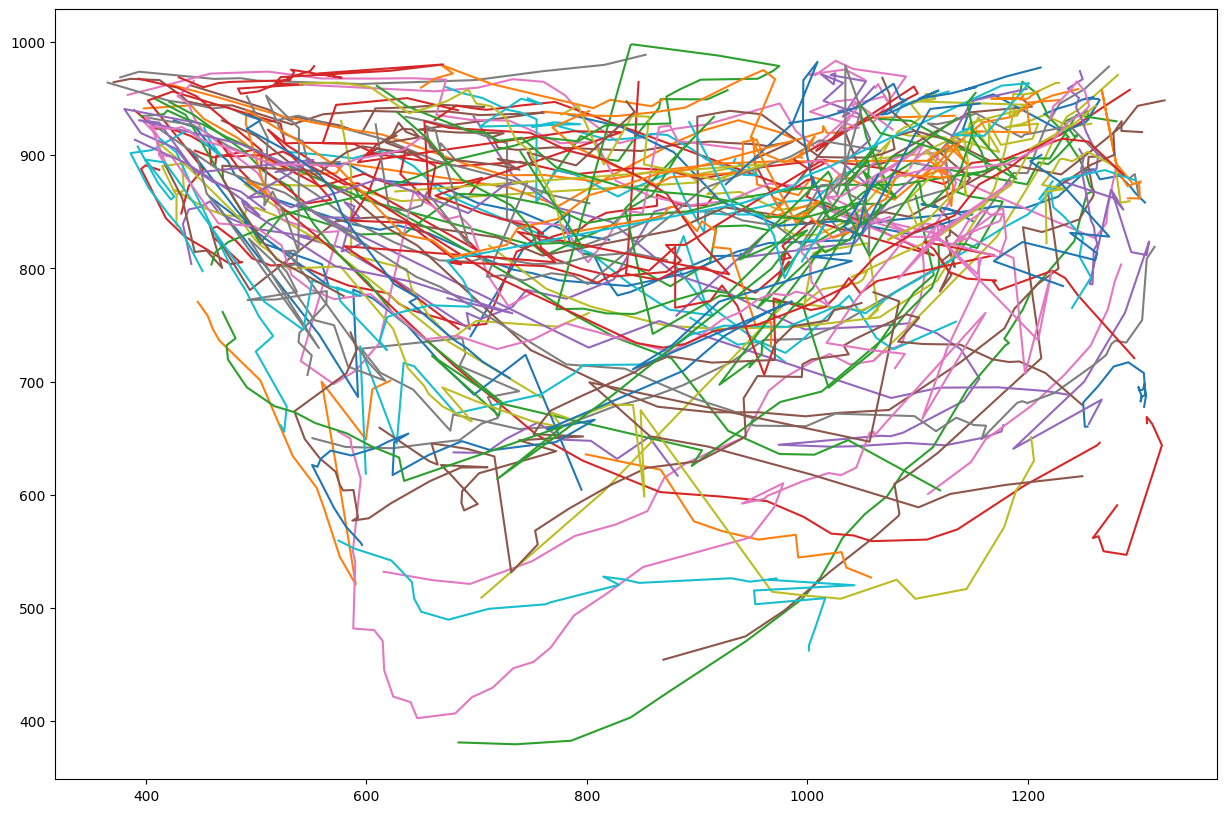

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

paper_data_count = 0

for storm_num, storm in paper_preproc.groupby('storm_num'):

    cy = storm.geometry.centroid.x
    cx = storm.geometry.centroid.y

    plt.plot(cx, cy, '-')

    paper_data_count += 1
        
print("paper data track count:", paper_data_count)

Example data:

example data track count: 113


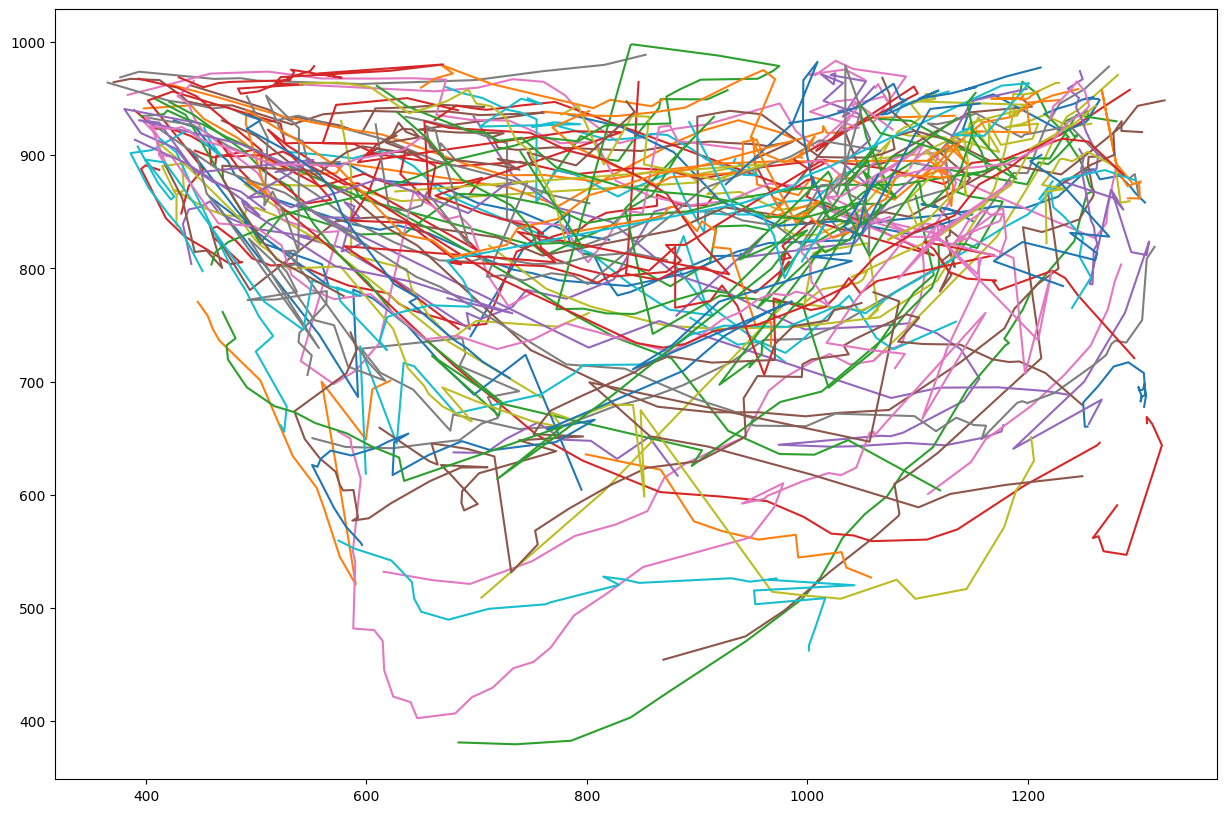

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

example_data_count = 0

for storm_num, storm in tracks.groupby('storm_num'):

    cy = storm.geometry.centroid.x
    cx = storm.geometry.centroid.y

    plt.plot(cx, cy, '-')

    example_data_count += 1
        
print("example data track count:", example_data_count)